# Taller 3: Clasificación de datos utilizando imágenes

In [51]:
import glob
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Rescaling, Conv2D, MaxPooling2D, Flatten, RandomZoom, RandomRotation, RandomFlip
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.io import read_file
from tensorflow.image import decode_png, resize
from tensorflow import expand_dims
from tensorflow.keras.callbacks import EarlyStopping

## Funciones

In [52]:
def generateMatrixConfusion(conf_matrix, class_names, modelo):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {modelo}')
    plt.show()

##  Regresion Logistica

### Procesado de imagenes

In [53]:
train_images = []
train_labels = []
errors = 0

for label, folder in enumerate(glob.glob("data/train/*")):
    for img_path in glob.glob(f"{folder}/*.png"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Verificar que la imagen se haya cargado correctamente
        if img is not None:
            img = cv2.resize(img, (128, 128)).flatten()
            train_images.append(img)
            train_labels.append(label)
        else:
            errors += 1
            print(f"Warning: No se pudo cargar la imagen {img_path}")
    else:
        print(f"Clase {label} cargada correctamente")
else:
    print(f"Se cargaron {len(train_images)} imágenes correctamente")
    print(f"Errores: {errors}")
    
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Clase 0 cargada correctamente
Clase 1 cargada correctamente
Clase 2 cargada correctamente
Clase 3 cargada correctamente
Clase 4 cargada correctamente
Clase 5 cargada correctamente
Clase 6 cargada correctamente
Clase 7 cargada correctamente
Clase 8 cargada correctamente
Clase 9 cargada correctamente
Clase 10 cargada correctamente
Clase 11 cargada correctamente
Clase 12 cargada correctamente
Clase 13 cargada correctamente
Clase 14 cargada correctamente
Clase 15 cargada correctamente
Se cargaron 5406 imágenes correctamente
Errores: 0


### Modelo

In [ ]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)

logreg = LogisticRegression(max_iter=10000) 
logreg.fit(train_images_scaled, train_labels)

train_predictions = logreg.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Accuracy en entrenamiento:", train_accuracy)

test_images = []
test_filenames = []

for img_path in glob.glob("data/test/*.png"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)).flatten()
    test_images.append(img)
    test_filenames.append(img_path.split("\\")[-1])

test_images = np.array(test_images)

test_images_scaled = scaler.transform(test_images)

test_predictions = logreg.predict(test_images_scaled)

class_labels = [folder.split("\\")[-1] for folder in sorted(glob.glob("data/train/*"))]
test_predictions_labels = [class_labels[pred] for pred in test_predictions]

submission_df = pd.DataFrame({
    "file": test_filenames,
    "label": test_predictions_labels
})

submission_df.to_csv("submission_logreg.csv", index=False)

Accuracy en entrenamiento: 0.7360340362560118


## Red covolucional

### Procesado de imagenes

In [ ]:
batch_size = 32
img_height = 260
img_width = 260
data_dir = "data/train"

train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5406 files belonging to 16 classes.
Using 4325 files for training.
Found 5406 files belonging to 16 classes.
Using 1081 files for validation.


In [71]:
class_names = train_ds.class_names
class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'cat',
 'cow',
 'dog',
 'horse']

In [72]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Definición del modelo

In [ ]:
num_classes = len(class_names)

data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  RandomRotation(0.1),
  RandomZoom(0.1),
])

# model = Sequential([
#   Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   Conv2D(16, 3, padding='same', activation='relu'),
#   MaxPooling2D(),
#   Conv2D(32, 3, padding='same', activation='relu'),
#   MaxPooling2D(),
#   Conv2D(64, 3, padding='same', activation='relu'),
#   MaxPooling2D(),
#   Flatten(),
#   Dense(128, activation='relu'),
#   Dense(num_classes)
# ])

resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
resnet_model.trainable = False

model = Sequential([
  data_augmentation,
  resnet_model,
  GlobalAveragePooling2D(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
])

In [74]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Entrenamiento del modelo

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/30


e:\Informacion\Downloads\taller\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


136/136 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.3602 - loss: 2.1007 - val_accuracy: 0.7521 - val_loss: 0.8281
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.6950 - loss: 0.9258 - val_accuracy: 0.8390 - val_loss: 0.5464
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.7820 - loss: 0.6931 - val_accuracy: 0.8908 - val_loss: 0.4057
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8062 - loss: 0.5726 - val_accuracy: 0.8908 - val_loss: 0.3728
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8467 - loss: 0.4604 - val_accuracy: 0.9038 - val_loss: 0.3251
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8591 - loss: 0.4121 - val_accuracy: 0.9029 - val_loss: 0.3062
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8712 - loss: 0.3933 - val_accuracy: 0.9038 - val_loss: 0.3012
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.8739 - loss: 0.3489 - val_accuracy: 0.915

## Matrices de confusión

34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


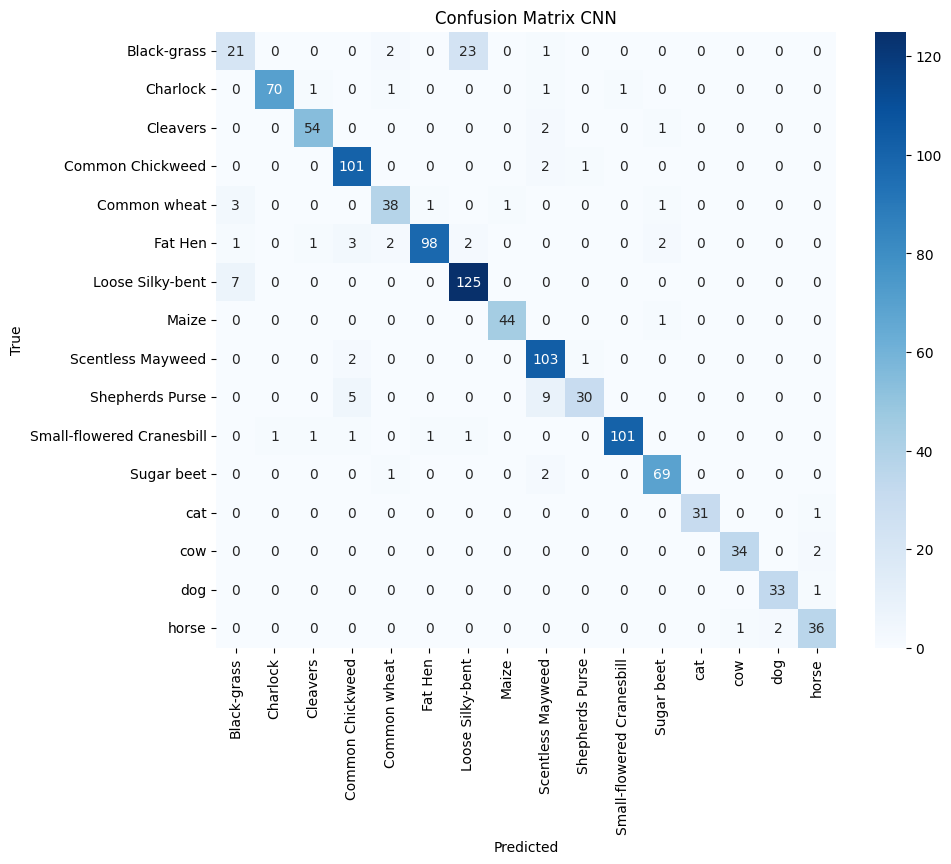

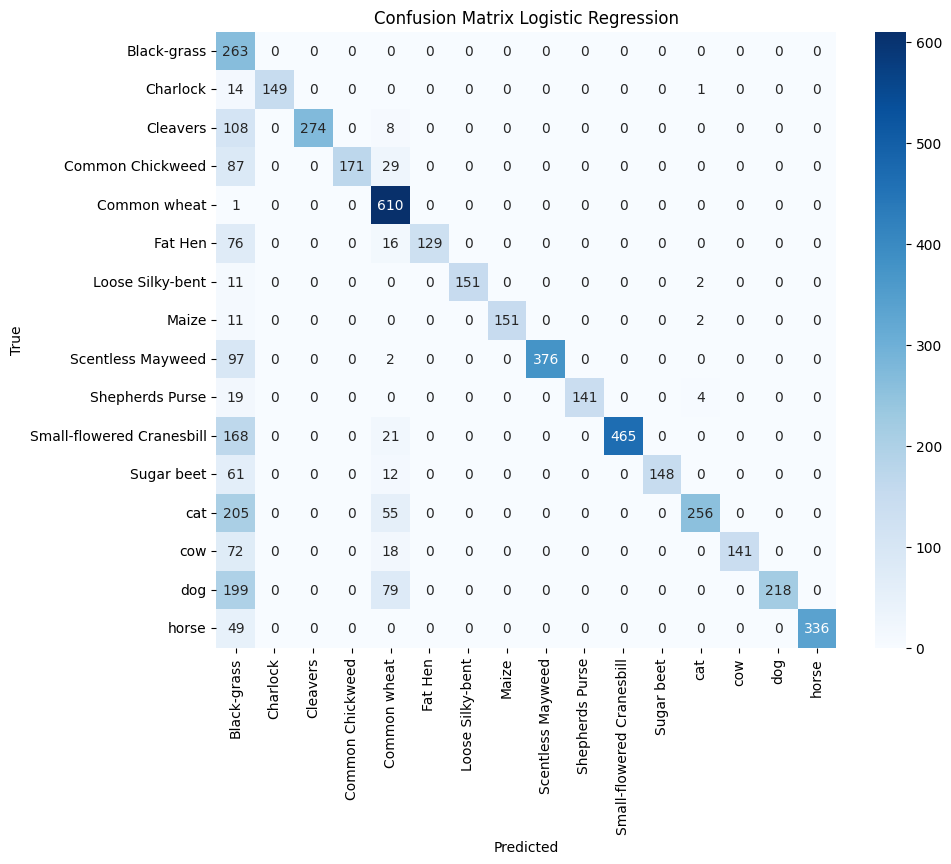

In [63]:
val_predictions = model.predict(val_ds)
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

conf_matrix_cnn = confusion_matrix(val_labels, val_predictions_classes)
generateMatrixConfusion(conf_matrix_cnn, class_names, "CNN")

conf_matrix_log = confusion_matrix(train_labels, train_predictions)
generateMatrixConfusion(conf_matrix_log, class_names, "Logistic Regression")

### Evaluación del modelo

In [62]:
test_data_dir = "data/test"
test_image_paths = glob.glob(os.path.join(test_data_dir, "*.png"))

def load_and_preprocess_image(path):
    img = read_file(path)
    img = decode_png(img, channels=3)
    img = resize(img, [img_height, img_width])
    img = expand_dims(img, 0)  # Add batch dimension
    return img

predictions = []
image_names = []

for img_path in test_image_paths:
        img = load_and_preprocess_image(img_path)
        preds = model.predict(img)
        predicted_class = np.argmax(preds, axis=1)
        predicted_class_name = class_names[predicted_class[0]]
        predictions.append(predicted_class_name)
        image_names.append(img_path)

results = pd.DataFrame({
        "file": [os.path.basename(name) for name in image_names],
        "label": predictions
})

results.to_csv("submission_cnn.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━